## Introduction:
There are many people who suffer from diabetic retinopathy, which is the leading cause of blindness.
The problem is as follows in fact sometimes it is necessary to make a diagnosis of the retina on a regular basis to detect if there is a danger of cesity and the doctor can thus do what he must do in order to prevent it. But in rural areas, it is sometimes difficult for patients to make these appointments. This is why the idea of ​​automating this diagnostic process is implemented. In fact, this project ultimately aims to be able to detect blindness before it occurs using artificial intelligence models precisely classifying images. The data is published in the kaggle platform and I used the keras and tensorflow frameworks for its realization.

This Kernel is forked from DimitreOliveira Kernel:
https://www.kaggle.com/dimitreoliveira/aptos-blindness-detection-eda-and-keras-resnet50


## Imports

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
import keras.callbacks
import tensorflow as tf
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
!ls ../input/aptos2019-blindness-detection

sample_submission.csv  test.csv  test_images  train.csv  train_images


In [ ]:
train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [ ]:
print(train.shape)
print(test.shape)

(3662, 2)
(1928, 1)


## Some EDA

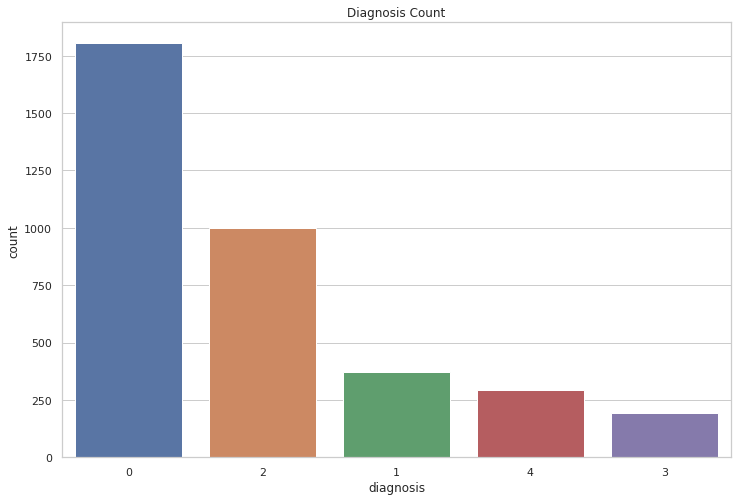

In [ ]:
# Let's plot the number of diagnosis 
plt.figure(figsize=(12,8))
plt.title('Diagnosis Count')
plt.xlabel('Diagnosis')
plt.ylabel('Number of samples')

sns.set_style("darkgrid")
sns.countplot(train["diagnosis"], order=train["diagnosis"].value_counts().index)

In [ ]:
# Percentage for each class
for i in range(5):
    percentage_i = (train[train["diagnosis"] == i].diagnosis.count() / train.diagnosis.count()) * 100
    print(f"Percentage for class {i} = {percentage_i} %")

Percentage for class 0 = 49.29000546149645 %
Percentage for class 1 = 10.10376843255052 %
Percentage for class 2 = 27.2801747678864 %
Percentage for class 3 = 5.270344074276352 %
Percentage for class 4 = 8.055707263790278 %


## Approaches to deal with Imbalanced Dataset
Our data is imbalanced. To handle this issue there are several options
* **Oversampling:**
There are two methods to apply oversampling. The first is called random oversmpling which involves randomly selecting samples from the minority class, with replacement, and adding them to the training dataset. (duplicating random samples from minority class). The second is by using augmentation on minority class.
* **Undersampling:**
involves randomly deleting samples from the majority class until we get the same proportion for all classes
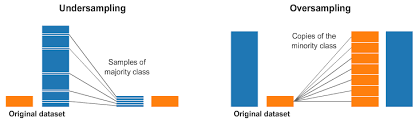

* **Apply Stratified Kfold as a validation Stratigy and F1-score as a metric for evaluation:** 
Stratified Kfold is a kfold strategy which makes the same distribution for both train and validation dataset.
The reason behind using F1-score metric is if we have an imbalanced data for example contains 99 "0" value and 1 "1" value and we use accuracy metric then we create a dumb model that predicts every new training data as 0 then we will get very high accuracy (0.99). Here, the model is accurate but not at all serving any value to our problem statement. That is why we will be using f1 score as the evaluation metric. F1 score is nothing but the harmonic mean of precision and recall. However, the evaluation metric is chosen based on the business problem and what type of error we want to reduce. For this competition, the metric chosen is Quadratic Weighted Kappa. 
The f1 score is the go-to metric when it comes to class imbalance problems.

                 f1 score = 2*(precision*recall)/(precision+recall)
                 precision = TP / (TP + FP)
                 recall = TP / (TP + FN)
                 
where: 

  TP: True Positive (Real value is Positive and the model predicted Positive)     
  TN: True Negative (Real value is Negative and the model predicted Negative)           
  FN: False Negative (Real value is Positive and the model predicted Negative)      
  FP: False Positive (Real value is Negative and the model predicted Positive)
  
                 Macro F1-score = (1/N) * sum(F1_score_i)

where: 
  N: is the number of classes
  F1_score_i: is the F1-score for binary classification between ith class vs all other classes.


* **Use Class Weights:** 
We can modify the current training algorithm to take into account the skewed distribution of the classes. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.
The formula associated to each weight_j is:
                                
                 weight_j = n_samples / (n_classes * n_samples_j)

   weight_j: is the weight for each class j

   n_samples: the total number of samples in the dataset
   
   n_classes: the total number of unique classes in the target
   
   n_samples_j: the total number of rows of the respective class j


I am going to apply the third and the fourth option:
1. I will use class_weights to assign weight for each class.
2. I will apply Stratified Kfold Strategy.

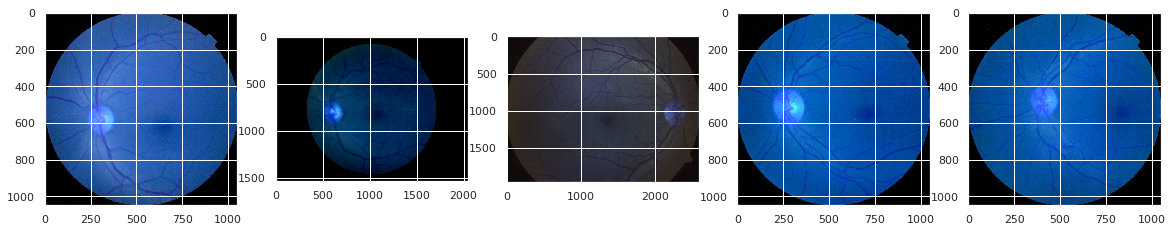

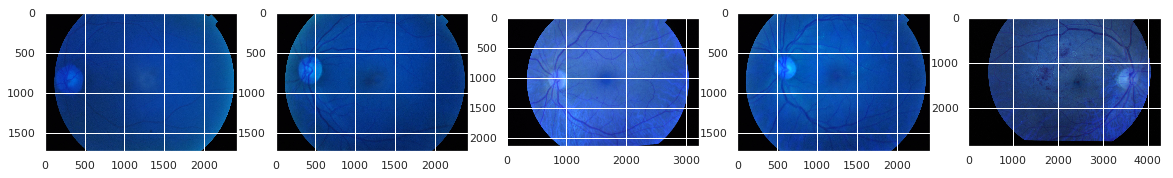

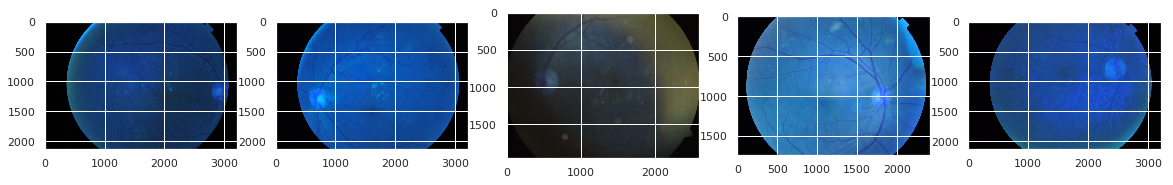

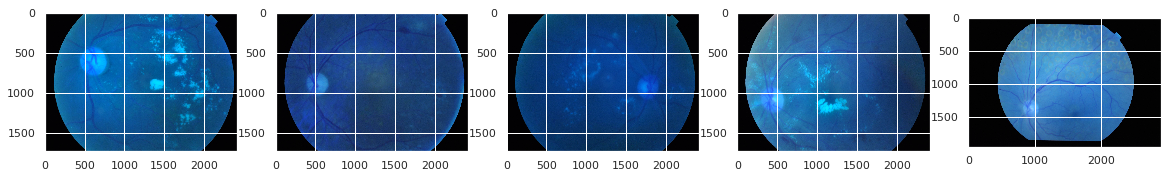

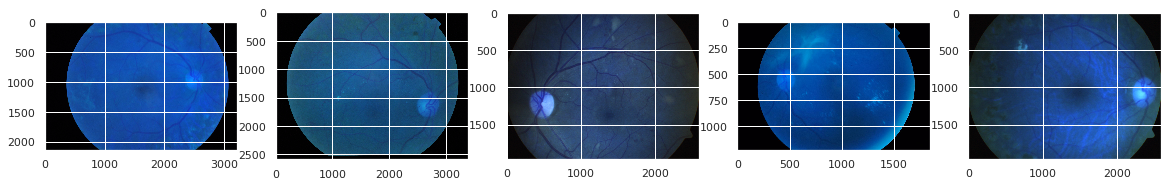

In [ ]:
# Let's visualize some images for each class
gp = train.groupby("diagnosis")
train_path = "../input/aptos2019-blindness-detection/train_images"
test_path = "../input/aptos2019-blindness-detection/test_images"
target = 0
for diagnosis in gp:
    plt.figure(figsize=[20, 20])
    plt.xlabel(f"Diagnosis = {diagnosis}")
    count = 1
    for img_name in diagnosis[1]["id_code"][:5]:
        path = f"{train_path}/{img_name}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, count)
        
        plt.imshow(image)
        plt.title(f"Diagnosis = {target}")
        
        count += 1
    target += 1

In [ ]:
"""
%%time
# Let's Analyse the size
# cv2.imread returns => (height, width, channels) 3D matrix
train["height"] =  train["id_code"].apply(lambda img_name: cv2.imread(f"{train_path}/{img_name}.png").shape[0])
train["width"] =  train["id_code"].apply(lambda img_name: cv2.imread(f"{train_path}/{img_name}.png").shape[1])
"""

'\n%%time\n# Let\'s Analyse the size\n# cv2.imread returns => (height, width, channels) 3D matrix\ntrain["height"] =  train["id_code"].apply(lambda img_name: cv2.imread(f"{train_path}/{img_name}.png").shape[0])\ntrain["width"] =  train["id_code"].apply(lambda img_name: cv2.imread(f"{train_path}/{img_name}.png").shape[1])\n'

In [ ]:
%%time
# Let's Analyse the size
# Image.open returns an Image object => .size() attribute returns (width, height) tuple
train["width"] =  train["id_code"].apply(lambda img_name: Image.open(f"{train_path}/{img_name}.png").size[0])
train["height"] =  train["id_code"].apply(lambda img_name: Image.open(f"{train_path}/{img_name}.png").size[1])
train.head()

CPU times: user 960 ms, sys: 1.28 s, total: 2.24 s
Wall time: 4.9 s


In [ ]:
%%time
# Let's Analyse the size
# Image.open returns an Image object => .size() attribute returns (width, height) tuple
test["width"] =  test["id_code"].apply(lambda img_name: Image.open(f"{test_path}/{img_name}.png").size[0])
test["height"] =  test["id_code"].apply(lambda img_name: Image.open(f"{test_path}/{img_name}.png").size[1])
test.head()

CPU times: user 392 ms, sys: 444 ms, total: 837 ms
Wall time: 1.94 s


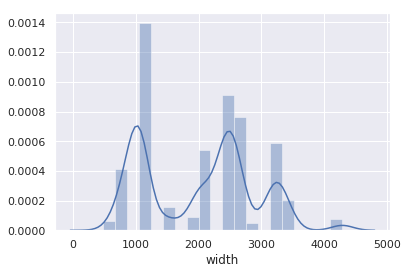

In [ ]:
sns.distplot(train["width"])

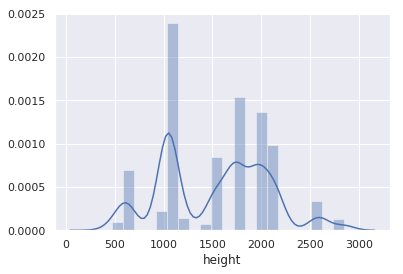

In [ ]:
sns.distplot(train["height"])

In [ ]:
print(train["width"].min())
print(train["height"].min())

474
358


In [ ]:
print(test["width"].min())
print(test["height"].min())

640
480


In [ ]:
print(train["width"].max())
print(train["height"].max())

4288
2848


In [ ]:
print(test["width"].max())
print(test["height"].max())

2896
1958


### Data With Different Shapes: What to do ?
![image.png](https://www.linkpicture.com/q/image_2020-12-20_174021.png)

As we can see if we increase the size of the image we get more information about the image

There are different approaches for this problem:

**Resize all the images to a chosen size** => What best size we can choose ? 
The problem with this approach is that we can't know the best choice for the size (that better gives performance) before we try. As a general rule the bigger the size the more information we get as input for the model. However when we fit a big size images the network fail to obtain reasonable accuracy due to the fact that there are not enough layers in the network. We need in one hand use a bigger and more complex CNN architecture to extract relevant features and in the other hand we need to avoid the problem of getting out of memory (as a solution for that is by reducing the batch size the training will then get slower).

**Padding** We can use **zero pad** the images when we feed them into the Network. In fact, zero padding creates a frame of zeros around each image => They take equal shape then. This approach is easy to implement as conv layers in keras come with already built-in zero padding arguments.
Or some deep learning researchers think that padding a big part of the image is not a good practice, since the neural network has to learn that the padded area is not relevant for classification.

I will go with the first option because the second one will probably cause a big problem for the model. In fact, we have a big difference between max and min shape. As example for training we have a difference <= 4288 - 640 for the width, and a difference <= 2848 - 480 for the height.

## Data Generator
### What is Data Generator ?
Data Generator is used to solve the problem of loading a dataset that does not fit the memory of the machine. In fact, it generates batches of tensor image data with real-time data augmentation. It's a regular Keras generator that uses a directory to find the images.

In [ ]:
# create 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   #rotation_range=45,
                                   validation_split=0.2,  
                                   horizontal_flip=True)  

# NB: Augmentation done only for training data
test_datagen = ImageDataGenerator(rescale=1./255)

# we must provide as input for method .flow_from_dataframe() a column file names (contains for each row "name_file_of_image"+".png") 
# and a label as str type
train["diagnosis"] = train["diagnosis"].astype('str')
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")

# Models
![](https://pythonawesome.com/content/images/2019/06/params.png)

What is transfer learning?
Transfer learning is the art of using pre-trained models to solve deep learning problems. A pre-trained model is nothing but a deep learning model someone else built and trained on some data to solve some problem.
I will use pretrained ResNet50, InceptionV3 and VGG16 on imagenet dataset. Then I will use ensemble technique (average and average weighted) to generate the predicted test set.
It is recommanded to use the same input shape for pretrained models as the shape of data pretrained on.

So I will go with (299, 299, 3) for InceptionV3

And for RestNet50 it is pretrained on (224, 224, 3) shape

For VGG16 it is pretrained on (224, 224, 3) shape

Freeze some layers and train the others: We can choose to freeze the initial k layers of a pre-trained model and train just the top most n-k layers. We keep the weights on the initial same as and constant as that of the pre-trained model and retrain the higher layers on our data. This approach is adopted when our dataset is small and the data similarity is also low. The lower layers focus on the most basic information that can be extracted from the data and hence this could be used as it is on another problem, as often the basic level information would be the same. For instance, the same curves and edges that make up the picture of a dog can make up a microscopic cancer cell.

DimitreOliveira used in his kernel a method called "warmup step". It is defined with two steps:
1. Freezing: Freeze the initial k layers of a pre-trained model and train just the top most n-k layers. 
2. Train again the whole model without using freezing (layer.trainable = True).

The intuition behind this is that the layers added to pretrained model (on the head) are initialized with random weights, but the rest of the network comes pre-trained on ImageNet, so the weights updated on the head would mess the whole network, that's why we need to first "warmup" the classifier head on the current task, then tune the whole network on the same task.


## Parameters of CNN Model

Let's understand the most essential hyperparameters in CNN:
### Batch Size: 
Training Neural Networks with a large data is pretty slow if we use as input the whole data and also the optimizer (gradient descent) will probably won't converge to the minimum of cost's curve. 
The idea of dividing The data into equal mini batches comes to life to solve this problem. The size of mini batches is known as the batch size.

NB: In mini-batch algorithm, the cost won't go down with each step as it does in batch algorithm. It could contain some ups and downs but generally it has to go down (unlike the batch gradient descent where cost function descreases on each iteration).


When mini batch size is equal to the len of data => Batch gradient descent

When mini batch size is equal to 1 => Stochastic gradient descent

When mini batch size is equal to a certain value m => Mini-batch gradient descent

### EPOCHS: 
The number of epochs defines the number of times the model will work through the entire training dataset.

### Learning Rate:
Learning Rate is a configurable hyperparameter used to control how much to change the model in response to the estimated error each time the model weights are updated. Learning rate is often in the range between 0.0 and 1.0.
Using too small learning rate makes the model converge slowly. 
Using too large learning rate can lead the model to diverge and can't find the minumum.
![Learning Rate](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

**In practice:**
![image.png](https://www.linkpicture.com/q/image_2020-12-20_175507.png) 

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 5
# Number of  epochs in the first step of "Warmup Step" approach
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
CANAL = 3 # R, G, B
N_CLASSES = train['diagnosis'].nunique() # number of unique values in target column

In [ ]:
# Exponential Decay (initial_lrate * exp(-k*t)) where k is a hyperparameter
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)
callback = keras.callbacks.LearningRateScheduler(scheduler)
    
## We can also use ReduceLROnPlateau as DimitreOliveira did.
###ReduceLROnPlateau reduces the learning rate by a factor chosen as input if the val_loss does not reduce after running five epochs.


# Define Class weights (the model accept class weights as a dicrionary: key represent the i_th class and value is the weight assigned to this class)
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['diagnosis'].astype('int').values), 
                                                  train['diagnosis'].astype('int').values)
class_weights = {i: class_weights[i] for i in range(5)}

In [ ]:
class_weights

{0: 0.4057617728531856,
 1: 1.9794594594594594,
 2: 0.7331331331331331,
 3: 3.7948186528497407,
 4: 2.4827118644067796}

## ResNet50
### Train top layers of ResNet50

In [ ]:
HEIGHT = 224
WIDTH = 224
img_directory = "../input/aptos2019-blindness-detection/train_images/"
img_test_directory = "../input/aptos2019-blindness-detection/test_images/"
train_data_generator = train_datagen.flow_from_dataframe(
    dataframe=train[["id_code", "diagnosis"]],
    directory=img_directory,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_data_generator = train_datagen.flow_from_dataframe(
    dataframe=train[["id_code", "diagnosis"]],
    directory=img_directory,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = img_test_directory,
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 0 validated image filenames.


In [ ]:
def create_model_ResNet50(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights="imagenet", include_top=False, 
                                       input_tensor=input_tensor)
    
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [ ]:
model_ResNet50 = create_model_ResNet50(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model_ResNet50.layers:
    layer.trainable = False
    
# Freeze all layers except last 5 (Number of layers to train on is a hyperparameter)
for i in range(-5, 0):
    model_ResNet50.layers[i].trainable = True

# optimizer
optimizer = optimizers.Adam(lr = LEARNING_RATE)

model_ResNet50.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
model_ResNet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# fit the model 
STEP_SIZE_TRAIN = train_data_generator.n//train_data_generator.batch_size
STEP_SIZE_VALID = valid_data_generator.n//valid_data_generator.batch_size

history_ResNet50 = model_ResNet50.fit_generator(train_data_generator, epochs=WARMUP_EPOCHS, validation_data=valid_data_generator,
                                                steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, class_weight=class_weights)

Epoch 1/2
366/366 [==============================] - 516s 1s/step - loss: 1.4960 - acc: 0.5423 - val_loss: 1.8417 - val_acc: 0.4629
Epoch 2/2
366/366 [==============================] - 446s 1s/step - loss: 1.2971 - acc: 0.6079 - val_loss: 1.8724 - val_acc: 0.4599


### Fine-Tune the complete model ReseNet50

In [ ]:
# Train the whole model
for layer in model_ResNet50.layers:
    layer.trainable = True

model_ResNet50.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# fit the model 
model_ResNet50.fit_generator(train_data_generator, epochs=EPOCHS, validation_data=valid_data_generator, 
                             steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, 
                             callbacks=[callback], class_weight=class_weights)

Epoch 1/5
366/366 [==============================] - 445s 1s/step - loss: 0.4242 - acc: 0.8651 - val_loss: 0.7334 - val_acc: 0.7555
Epoch 2/5
366/366 [==============================] - 431s 1s/step - loss: 0.3918 - acc: 0.8832 - val_loss: 0.6672 - val_acc: 0.7859
Epoch 3/5
366/366 [==============================] - 415s 1s/step - loss: 0.3456 - acc: 0.8870 - val_loss: 0.5987 - val_acc: 0.8066
Epoch 4/5
366/366 [==============================] - 414s 1s/step - loss: 0.3509 - acc: 0.9061 - val_loss: 1.0723 - val_acc: 0.7293
Epoch 5/5
366/366 [==============================] - 426s 1s/step - loss: 0.2696 - acc: 0.9211 - val_loss: 0.7224 - val_acc: 0.8094


### Evaluation on all data and Inference on Test Data 

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=train, directory = img_directory,
                                                          x_col="id_code", target_size=(HEIGHT, WIDTH),
                                                          batch_size=1, shuffle=False, class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds_ResNet50 = model_ResNet50.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds_ResNet50

Found 3662 validated image filenames.


array([[9.36566551e-07, 5.44862414e-04, 9.77546275e-01, 9.29111335e-03,
        1.26168085e-02],
       [1.11351703e-07, 2.42219517e-06, 4.08637570e-03, 9.02291853e-03,
        9.86888230e-01],
       [4.19772882e-03, 9.87844527e-01, 7.89691694e-03, 5.69163035e-07,
        6.02813452e-05],
       ...,
       [1.88528866e-05, 4.47131781e-04, 9.39718425e-01, 2.03775354e-02,
        3.94380093e-02],
       [9.99845386e-01, 1.53857764e-04, 7.04450372e-07, 6.57710345e-11,
        6.39925313e-09],
       [1.37530549e-07, 1.42624602e-03, 9.95337486e-01, 1.82036695e-03,
        1.41575898e-03]], dtype=float32)

In [ ]:
# Quadratic Weighted Kappa
Eval_preds_ResNet50 = [np.argmax(pred) for pred in train_preds_ResNet50]
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(Eval_preds_ResNet50, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.965


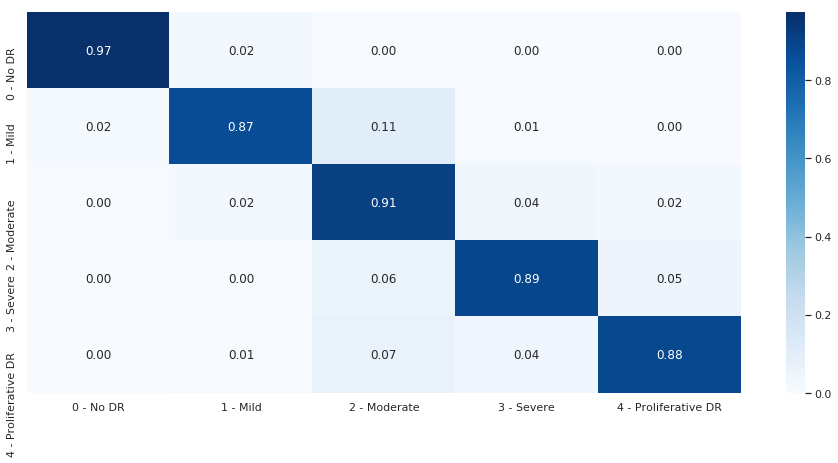

In [ ]:
# Confusion Matrix
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), Eval_preds_ResNet50)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
# Predict Test Data
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds_ResNet50 = model_ResNet50.predict_generator(test_generator, steps=STEP_SIZE_TEST)
test_preds_ResNet50
#predictions_ResNet50 = [np.argmax(pred) for pred in preds]

array([[1.59229356e-04, 1.03662256e-02, 9.00795639e-01, 8.78566969e-03,
        7.98932537e-02],
       [8.91518066e-05, 8.90264520e-04, 4.68844175e-01, 3.52356791e-01,
        1.77819535e-01],
       [1.85407589e-05, 3.80029727e-04, 3.37098241e-01, 6.38590574e-01,
        2.39126105e-02],
       ...,
       [2.14088977e-05, 2.92443740e-03, 9.07582998e-01, 6.90819100e-02,
        2.03893166e-02],
       [1.41178056e-08, 6.05245759e-07, 2.80282169e-04, 3.41671193e-03,
        9.96302366e-01],
       [1.09907258e-02, 1.79840863e-01, 7.81532586e-01, 1.20647885e-02,
        1.55710522e-02]], dtype=float32)

## VGG16
### Train top layers of VGG16

In [ ]:
HEIGHT = 224
WIDTH = 224
img_directory = "../input/aptos2019-blindness-detection/train_images/"
img_test_directory = "../input/aptos2019-blindness-detection/train_images/"
train_data_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_directory,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training',
    shuffle=True)

valid_data_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_directory,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation',
    shuffle=True)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = img_test_directory,
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 0 validated image filenames.


In [ ]:
def create_model_VGG16(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.VGG16(weights="imagenet", include_top=False, 
                                       input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [ ]:
model_VGG16 = create_model_VGG16(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model_VGG16.layers:
    layer.trainable = False
    
# Freeze all layers except last 5 (Number of layers to train on is a hyperparameter)
for i in range(-5, 0):
    model_VGG16.layers[i].trainable = True

optimizer = optimizers.SGD(LEARNING_RATE, momentum=0.9)  
model_VGG16.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
model_VGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
# fit the model 
STEP_SIZE_TRAIN = train_data_generator.n//train_data_generator.batch_size
STEP_SIZE_VALID = valid_data_generator.n//valid_data_generator.batch_size

model_VGG16.fit_generator(train_data_generator, epochs=WARMUP_EPOCHS, validation_data=valid_data_generator,
                          steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, 
                          class_weight=class_weights)

Epoch 1/2
366/366 [==============================] - 401s 1s/step - loss: 1.6420 - acc: 0.3094 - val_loss: 1.5412 - val_acc: 0.4409
Epoch 2/2
366/366 [==============================] - 381s 1s/step - loss: 1.6170 - acc: 0.2900 - val_loss: 1.5502 - val_acc: 0.4489


### Fine-Tune the complete model VGG16

In [ ]:
# Train the whole model
for layer in model_VGG16.layers:
    layer.trainable = True
    
model_VGG16.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# fit the model 
model_VGG16.fit_generator(train_data_generator, epochs=EPOCHS, validation_data=valid_data_generator, 
                          steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, 
                          callbacks=[callback], class_weight=class_weights)

Epoch 1/5
366/366 [==============================] - 401s 1s/step - loss: 1.5634 - acc: 0.4303 - val_loss: 1.2637 - val_acc: 0.4945
Epoch 2/5
366/366 [==============================] - 384s 1s/step - loss: 1.4397 - acc: 0.5536 - val_loss: 1.2292 - val_acc: 0.4793
Epoch 3/5
366/366 [==============================] - 382s 1s/step - loss: 1.3898 - acc: 0.5693 - val_loss: 1.1059 - val_acc: 0.5704
Epoch 4/5
366/366 [==============================] - 394s 1s/step - loss: 1.3905 - acc: 0.5721 - val_loss: 1.2511 - val_acc: 0.4530
Epoch 5/5
366/366 [==============================] - 410s 1s/step - loss: 1.3566 - acc: 0.5830 - val_loss: 1.0388 - val_acc: 0.4903


### Evaluation on all data and Inference on Test Data 

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=train, directory = img_directory,
                                                          x_col="id_code", target_size=(HEIGHT, WIDTH),
                                                          batch_size=1, shuffle=False, class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds_VGG16 = model_VGG16.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
#train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


In [ ]:
train_preds_VGG16

array([[0.04979464, 0.23580728, 0.2509662 , 0.1893804 , 0.27405152],
       [0.04319051, 0.24128322, 0.25827307, 0.17744532, 0.27980793],
       [0.06132891, 0.23636103, 0.2415641 , 0.19090033, 0.26984566],
       ...,
       [0.04438505, 0.24073093, 0.2560844 , 0.1783546 , 0.280445  ],
       [0.842251  , 0.03546862, 0.05426489, 0.03497374, 0.03304185],
       [0.16627787, 0.19595453, 0.18534143, 0.23563188, 0.21679422]],
      dtype=float32)

In [ ]:
# Quadratic Weighted Kappa
Eval_preds_VGG16 = [np.argmax(pred) for pred in train_preds_VGG16]
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(Eval_preds_VGG16, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.609


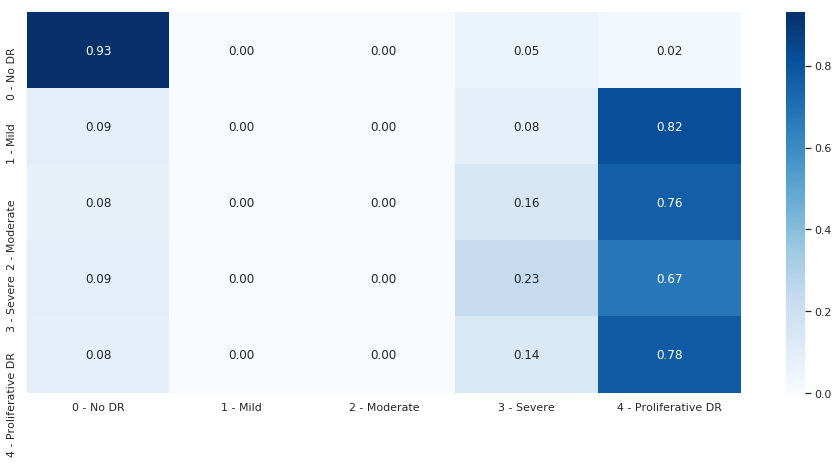

In [ ]:
# Confusion Matrix
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), Eval_preds_VGG16)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
# Predict Test Data
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds_VGG16 = model_VGG16.predict_generator(test_generator, steps=STEP_SIZE_TEST)
test_preds_VGG16
#predictions_ResNet50 = [np.argmax(pred) for pred in preds]

array([[0.11959007, 0.21239237, 0.19985987, 0.23514952, 0.23300822],
       [0.12700883, 0.20898801, 0.19909179, 0.23505075, 0.2298606 ],
       [0.12772325, 0.21016312, 0.19945627, 0.23359478, 0.22906256],
       ...,
       [0.12533964, 0.20956144, 0.2003908 , 0.2353752 , 0.22933291],
       [0.06098539, 0.23589376, 0.24103594, 0.19164385, 0.27044106],
       [0.74989253, 0.05330299, 0.0775    , 0.06074917, 0.05855534]],
      dtype=float32)

## Inception V3
### Train top layers of InceptionV3

In [ ]:
HEIGHT = 299
WIDTH = 299
img_directory = "../input/aptos2019-blindness-detection/train_images/"
img_test_directory = "../input/aptos2019-blindness-detection/train_images/"
train_data_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_directory,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training',
    shuffle=True)

valid_data_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_directory,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation',
    shuffle=True)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = img_test_directory,
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 0 validated image filenames.


In [ ]:
def create_model_InceptionV3(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.InceptionV3(weights="imagenet", include_top=False, 
                                          input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [ ]:
model_InceptionV3 = create_model_InceptionV3(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model_InceptionV3.layers:
    layer.trainable = False
    
# Freeze all layers except last 5 (Number of layers to train on is a hyperparameter)
for i in range(-5, 0):
    model_InceptionV3.layers[i].trainable = True

optimizer = optimizers.Adam(lr=LEARNING_RATE)  
model_InceptionV3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
model_InceptionV3.summary()

87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________

In [ ]:
# fit the model 
STEP_SIZE_TRAIN = train_data_generator.n//train_data_generator.batch_size
STEP_SIZE_VALID = valid_data_generator.n//valid_data_generator.batch_size

model_InceptionV3.fit_generator(train_data_generator, epochs=WARMUP_EPOCHS, validation_data=valid_data_generator,
                          steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, class_weight=class_weights)

Epoch 1/2
366/366 [==============================] - 434s 1s/step - loss: 1.5882 - acc: 0.3480 - val_loss: 1.4956 - val_acc: 0.4808
Epoch 2/2
366/366 [==============================] - 421s 1s/step - loss: 1.4879 - acc: 0.5195 - val_loss: 1.3626 - val_acc: 0.5235


### Fine-Tune the complete model InceptionV3

In [ ]:
# Train the whole model
for layer in model_InceptionV3.layers:
    layer.trainable = True
    
model_InceptionV3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# fit the model 
model_InceptionV3.fit_generator(train_data_generator, epochs=EPOCHS, validation_data=valid_data_generator, 
                                steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, 
                                callbacks=[callback], class_weight=class_weights)

Epoch 1/5
366/366 [==============================] - 468s 1s/step - loss: 1.3853 - acc: 0.5523 - val_loss: 1.0141 - val_acc: 0.6575
Epoch 2/5
366/366 [==============================] - 419s 1s/step - loss: 1.1593 - acc: 0.6451 - val_loss: 0.7734 - val_acc: 0.6934
Epoch 3/5
366/366 [==============================] - 400s 1s/step - loss: 1.0335 - acc: 0.6875 - val_loss: 1.6827 - val_acc: 0.4061
Epoch 4/5
366/366 [==============================] - 423s 1s/step - loss: 0.9305 - acc: 0.7155 - val_loss: 0.6414 - val_acc: 0.7762
Epoch 5/5
366/366 [==============================] - 431s 1s/step - loss: 0.8403 - acc: 0.7466 - val_loss: 0.6522 - val_acc: 0.7569


### Evaluation on all data and Inference on Test Data 

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=train, directory = img_directory,
                                                          x_col="id_code", target_size=(HEIGHT, WIDTH),
                                                          batch_size=1, shuffle=False, class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds_InceptionV3 = model_InceptionV3.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
#train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


In [ ]:
# Quadratic Weighted Kappa
Eval_preds_InceptionV3 = [np.argmax(pred) for pred in train_preds_InceptionV3]
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(Eval_preds_InceptionV3, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.885


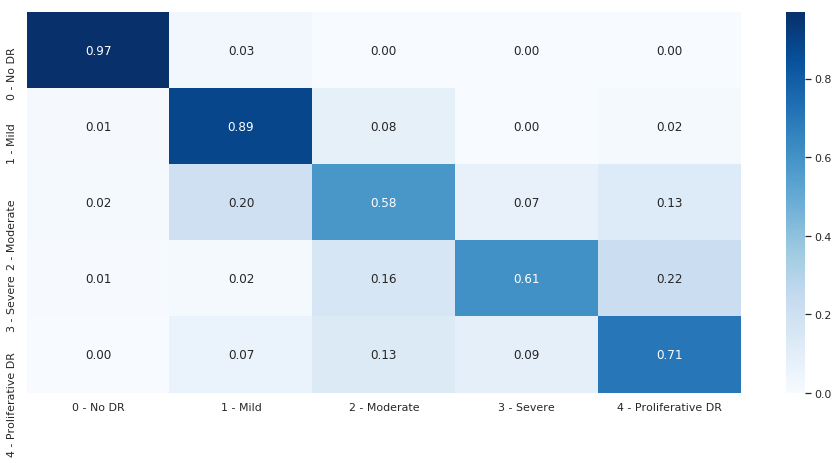

In [ ]:
# Confusion Matrix
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), Eval_preds_InceptionV3)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
# Predict Test Data
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds_InceptionV3 = model_InceptionV3.predict_generator(test_generator, steps=STEP_SIZE_TEST)
test_preds_InceptionV3
#predictions_ResNet50 = [np.argmax(pred) for pred in preds]

array([[0.01916698, 0.5245029 , 0.23774582, 0.07707761, 0.1415067 ],
       [0.00202967, 0.00189349, 0.04602799, 0.9059417 , 0.04410711],
       [0.00131156, 0.01292617, 0.17492045, 0.58837414, 0.22246769],
       ...,
       [0.00456286, 0.04200105, 0.3645092 , 0.37370265, 0.21522425],
       [0.00313519, 0.01017932, 0.12937179, 0.6927488 , 0.16456488],
       [0.7735078 , 0.11109963, 0.06199536, 0.04516777, 0.00822946]],
      dtype=float32)

## Ensembling
### Averaging Ensemble

In [ ]:
train_preds_averaged = (train_preds_InceptionV3 + train_preds_VGG16 + train_preds_ResNet50) / 3
Eval_preds_averaged = [np.argmax(pred) for pred in train_preds_averaged]

print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(Eval_preds_averaged, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.962


### Weighted Average Ensemble

In [ ]:
train_preds_weighted = (train_preds_InceptionV3*0.25 + train_preds_VGG16*0.15 + train_preds_ResNet50*0.6)
Eval_preds_weighted = [np.argmax(pred) for pred in train_preds_weighted]

print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(Eval_preds_weighted, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.966


### Predict target for Test Data (Weighted Average)

In [ ]:
# Predict Test Data
test_preds_weighted = test_preds_InceptionV3*0.25 + test_preds_VGG16*0.15 + test_preds_ResNet50*0.6
Predictions = [np.argmax(pred) for pred in test_preds_weighted]
Predictions

[2,
 3,
 3,
 2,
 2,
 2,
 3,
 1,
 3,
 0,
 1,
 3,
 0,
 2,
 2,
 2,
 2,
 2,
 4,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 3,
 2,
 2,
 2,
 4,
 1,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 0,
 2,
 0,
 1,
 4,
 2,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 4,
 0,
 2,
 2,
 1,
 1,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 1,
 1,
 2,
 3,
 1,
 0,
 0,
 2,
 2,
 2,
 3,
 3,
 2,
 0,
 3,
 3,
 3,
 3,
 2,
 2,
 4,
 0,
 2,
 2,
 0,
 0,
 3,
 2,
 3,
 3,
 2,
 2,
 0,
 2,
 0,
 2,
 3,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 4,
 1,
 4,
 3,
 2,
 0,
 2,
 0,
 4,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 3,
 2,
 0,
 2,
 4,
 2,
 3,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 4,
 3,
 1,
 2,
 2,
 3,
 0,
 0,
 3,
 4,
 2,
 2,
 4,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 4,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 3,
 2,
 2,
 0,
 2,
 2,
 3,
 1,
 2,
 3,
 0,
 1,
 2,
 4,
 2,
 2,
 2,
 0,
 2,
 3,
 3,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 0,
 3,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,


In [ ]:
test["diagnosis"] = Predictions
test.head()

,id_code,diagnosis
0,0005cfc8afb6.png,2
1,003f0afdcd15.png,3
2,006efc72b638.png,3
3,00836aaacf06.png,2
4,009245722fa4.png,2


## Second Approach: Stratified Kfold + F1-Score
### K-Fold CV:
is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. Lets take the scenario of 5-Fold cross validation(K=5). Here, the data set is split into 5 folds. In the first iteration, the first fold is used to valid the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the validatiion set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the validation set.

![image.png](https://www.linkpicture.com/q/image_2020-12-21_083922.png)

### Stratified CV:
![](https://www.linkpicture.com/q/Screenshot-from-2020-12-19-12-47-47.png)

Stratification seeks to ensure that each fold is representative of all classes of the data and distributed as the same as the whole training data. Generally this is done in a supervised way for classification and aims to ensure each class is (approximately) equally represented across each test fold (which are of course combined in a complementary way to form training folds).

In [ ]:
# Stratified KFold
Y = train[['diagnosis']]
skf = StratifiedKFold(n_splits = 5, random_state = 25, shuffle = True) 

In [ ]:
# F1 score is not implemented in metrics list parameter we should so define a function that calculate F1 score 
# Code Source for macro F1 score function: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
import tensorflow as tf
import keras.backend as K

def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
valid_preds = []
valid_real = []
F1-score = []
HEIGHT = 224
WIDTH = 224
fold = 1

test_generator = test_datagen.flow_from_dataframe(dataframe=test, directory = img_test_directory, 
                                                  x_col="id_code", target_size=(HEIGHT, WIDTH),
                                                  batch_size=1, shuffle=False, class_mode=None)

optimizer = optimizers.Adam(lr = LEARNING_RATE)

for train_index, val_index in skf.split(np.zeros(train.shape[0]), y=Y):
    training_data = train.iloc[train_index]
    validation_data = train.iloc[val_index]
    train_data_generator = train_datagen.flow_from_dataframe(training_data, directory = img_directory,
                                                             x_col = "id_code", y_col = "diagnosis",
                                                             batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH),
                                                             class_mode = "categorical", shuffle = True)
    
    valid_data_generator = train_datagen.flow_from_dataframe(validation_data, directory = img_directory,
                                                             x_col = "id_code", y_col = "diagnosis",
                                                             batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH),
                                                             class_mode = "categorical", shuffle = True)
    
    
    
    
    # CREATE NEW MODEL
    model_ResNet50 = create_model_ResNet50(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

    for layer in model_ResNet50.layers:
        layer.trainable = True
    
    
    # COMPILE NEW MODEL
    model_ResNet50.compile(loss='categorical_crossentropy', optimizer=optimizer) 
    
    
    # FIT THE MODEL 
    STEP_SIZE_TRAIN = train_data_generator.n//train_data_generator.batch_size
    STEP_SIZE_VALID = valid_data_generator.n//valid_data_generator.batch_size
    model_ResNet50.fit_generator(train_data_generator, epochs=EPOCHS, validation_data=valid_data_generator, 
                                 steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, 
                                 callbacks=[callback])
    
    # Generate prediction on validation 
    STEP_SIZE = valid_data_generator.n//valid_data_generator.batch_size
    valid_preds_skf = model_ResNet50.predict_generator(valid_data_generator, steps=STEP_SIZE_COMPLETE)
    valid_preds_skf = [np.argmax(pred) for pred in valid_preds_skf]
    valid_preds.append(valid_preds_skf)
    valid_real.append(list(validation_data))
    
    F1-score.append(f1_m(np.array(validation_data), np.array(valid_preds_skf)))
    
    # Predict Test
    test_generator.reset()
    STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
    test_preds_SKF = model_ResNet50.predict_generator(test_generator, steps=STEP_SIZE_TEST)
    test_preds_SKF = [np.argmax(pred) for pred in test_preds_SKF]
    if fold == 1:
        TEST_PREDICTION = test_preds_SKF
    else:
        TEST_PREDICTION = TEST_PREDICTION + test_preds_SKF


    tf.keras.backend.clear_session()
    
    fold = fold + 1

print(f1_m(np.array(valid_real), np.array(valid_preds)))
TEST_PREDICTION = TEST_PREDICTION / 5
print(TEST_PREDICTION)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.
Epoch 1/1
366/366 [==============================] - 520s 1s/step - loss: 0.8377 - val_loss: 0.6404


KeyboardInterrupt: 

# Hyperparameter Tuning:
## Number of neurons per layer:
When we increase this parameter the network can learn more complex decision boundaries and so it will overfit faster.
## Number of layers:
If we think that our network is not powerful enough then we need to try to add some other layers and see what happens. The best recommandation is to start with something very simple say 1 or 2 layers and 64 units per layer. Debug the code and make sure the training and validation loss go down then we try to find a configuration that is able to fit better the training set.
## Optimizers:
* **SGD + momentum:** converge slower but the trained network usually generalizes better
* **Adam/adadelta/adagrad:** in practice lead to more overfitting

## Batch size: 
It turns out that increasing batch size leads to more overfitting (however it spead up the training process). The recommendation is to pick a value around 32 or 64 then if we see the network is still overfitting we try then to decrease it. 
NB: The batch size also should not be too small, the gradient will be too noisy.

## Learning rate: 
When the learning rate is too high network will not converge and with too small learning rate, the netwrok will learn forever. The good approach is to start with a huge learning rate, say 0.1 and try to lower it down till we find one with which network converges.

## Tip: A connection between the batch size and the learning rate:
There is a Trick that I got from How to win a data science competition learn from top kagglers: 
If we increase the batch size by a factor of alpha, we should  then increase learning rate by the same factor but we should remember the larger batch size the more the network prone to overfitting => We need a good regularization here

## Regularization:
Techniques of Regularization that we can use to reduce overfitting are:
* L2/L1 Regularization for weights (we just add the parameter kernel_regularizer = tf.keras.regularizers.l1(0.01) to the Dense layer)
* Dropout/Dropconnect: Usually add the dropout layer closer to the end of the network, but its okay to add some dropout to every layer, it should also works.
* Static Dropconnect: The idea of this approach is to use a first hidden layer with a very huge number of units, say 4096 units and at random drop 99% of connections between the input layer and the first hidden layer.
![](https://www.linkpicture.com/q/Screenshot-from-2020-12-19-09-41-34.png)

# What we Can do more ?
## stacking: 
It is an advanced ensemble method. It should provides a more robust model.
How Stacking works ?
Wolpert in 1992 introduced stacking as follow:
1. Splitting the train set into two disjoint sets.
2. Train several base learners on the first part. 
3. Make predictions with the base learners on the second (validation) part.
4. Using the predictions from (3) as the inputs to train a higher level learner.

![](https://www.linkpicture.com/q/Screenshot-from-2020-12-19-09-38-59.png)

(Source: KazAnova (research data science at h2O.ai, phd in ensemble methods and was the former #1)

## Manual Augmentation using Image Processing Techniques: 
Like Dilatation, Erosion, Background Substraction, Image Segmentation and so on.